# Continuous Control


In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10099999774247408


When finished, you can close the environment.

In [6]:
#env.close()

### 4. Train your agent


###### 4.1 Learning algorithm -  DDPG

Deep Deterministic Policy Gradient was proposed in Continuous control with deep reinforcement learning(Lillicrap et al, 2015). DDPG is an off policy algorithm and can only be used only for continuous action spaces. It simultaneously learns a function and a policy. It's an actor critic algorithm and uses two neural networks. The algorithm also applies experience replay and target networks to stabilize the training. To boost exploration, the authors of the DDPG paper have used Ornstein-Uhlenbeck Process to add noise to the action output.


###### 4.1 Model architecture

The Actor network consist of three fully connected layer with batchnormalization applied at the first layer. The network maps states to actions. It uses ReLU as activation function except the last layer where it use tanh. 

The critic network also consist of three fully connected layer with batchnormalization applied at the first layer. The network maps maps (state,action) pairs to Q-values. It uses ReLU as activation function in the first two layers and no activation function for the last layer.

###### 4.1 Hyperparameters

* fc1_units=400 # Number of nodes in the first hidden layer
* fc2_units=300 # Number of nodes in the second hidden layer
* BUFFER_SIZE = int(1e6) # replay buffer size
* BATCH_SIZE = 128       # minibatch size
* GAMMA = 0.99           # discount factor
* TAU = 1e-3             # for soft update of target parameters
* LR_ACTOR = 1e-3        # learning rate of the actor
* LR_CRITIC = 1e-3       # learning rate of the critic
* WEIGHT_DECAY = 0       # L2 weight decay
* LEARN_EVERY = 20       # learning timestep interval
* LEARN_NUM = 10            # number of learning passes
* GRAD_CLIPPING = 1.0         # gradient clipping 
* OU_SIGMA = 0.2 # OU noise parameter
* OU_THETA = 0.15 # OU noise parameter
* EPSILON = 1.0         # for epsilon in the noise process (act step)
* EPSILON_DECAY = 1e-6 3 epsilon decay rate
* num_episodes=2500 # maximum number of training episodes
* max_t=1000 # maximum number of timesteps per episode

In [5]:
import numpy as np
import random
import time
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [6]:
seed = 3

In [7]:
# DDPG function
def ddpg(num_episodes=2500, max_t=1000, print_every=1, actor_weights_name='actor.pth', critic_weights_name='critic.pth'):
    """Deep Deterministic Policy Gradient
    
    Params
    ======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    print_every (int): interval to display results
    
    """
    mean_scores = [] # list of mean scores from each episode
    moving_avgs = [] # list of moving averages
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes
    
    for i_episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations # get current state for each observations
        scores = np.zeros(num_agents) # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True) # select an action
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations # get next state (for each agent)
            rewards = env_info.rewards # get reward (for each agent)
            dones = env_info.local_done # see if episode finished
            # perform learning step
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        mean_scores.append(np.mean(scores)) # save mean score for each episode
        scores_window.append(mean_scores[-1]) # save mean score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average
        
        if i_episode % print_every == 0:
            print("\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}"\
                  .format(i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
        if moving_avgs[-1] >= 30.0:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.2f}"\
                 .format(i_episode, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), actor_weights_name)
            torch.save(agent.critic_local.state_dict(), critic_weights_name)
            break
            
    return mean_scores, moving_avgs
    

In [8]:
# start the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

In [9]:
scores, avgs = ddpg(actor_weights_name ='actor_single.pth', critic_weights_name='critic_single.pth')

Episode 1 (49s)	Mean: 0.9	Moving Avg: 0.9
Episode 2 (50s)	Mean: 2.1	Moving Avg: 1.5
Episode 3 (52s)	Mean: 2.2	Moving Avg: 1.7
Episode 4 (52s)	Mean: 2.8	Moving Avg: 2.0
Episode 5 (53s)	Mean: 4.6	Moving Avg: 2.5
Episode 6 (53s)	Mean: 5.4	Moving Avg: 3.0
Episode 7 (54s)	Mean: 6.0	Moving Avg: 3.4
Episode 8 (54s)	Mean: 6.1	Moving Avg: 3.8
Episode 9 (55s)	Mean: 6.4	Moving Avg: 4.0
Episode 10 (58s)	Mean: 9.9	Moving Avg: 4.6
Episode 11 (57s)	Mean: 9.9	Moving Avg: 5.1
Episode 12 (60s)	Mean: 12.9	Moving Avg: 5.8
Episode 13 (65s)	Mean: 14.7	Moving Avg: 6.4
Episode 14 (62s)	Mean: 17.5	Moving Avg: 7.2
Episode 15 (63s)	Mean: 16.2	Moving Avg: 7.8
Episode 16 (64s)	Mean: 18.3	Moving Avg: 8.5
Episode 17 (65s)	Mean: 19.0	Moving Avg: 9.1
Episode 18 (66s)	Mean: 19.2	Moving Avg: 9.7
Episode 19 (68s)	Mean: 19.8	Moving Avg: 10.2
Episode 20 (68s)	Mean: 23.3	Moving Avg: 10.9
Episode 21 (71s)	Mean: 22.3	Moving Avg: 11.4
Episode 22 (72s)	Mean: 23.5	Moving Avg: 11.9
Episode 23 (72s)	Mean: 25.2	Moving Avg: 12.5
Epi

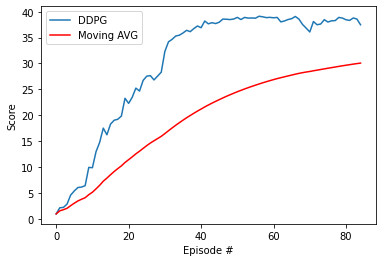

In [11]:
# plot scores across episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


In [15]:
env.close()

### 5. Future ideas to improve the agent's performance

* DDPG can be improved by using prioritized experience replay. 
* Fine-tuning of hperparameters can also lead to better results and faster training time.
